<a href="https://colab.research.google.com/github/polina-minaeva/Convolutional-Neural-Network-Training/blob/main/5_%D0%9E%D0%B1%D1%83%D1%87%D0%B5%D0%BD%D0%B8%D0%B5_%D1%81%D0%B2%D0%B5%D1%80%D1%82%D0%BE%D1%87%D0%BD%D0%BE%D0%B9_%D0%9D%D0%A1_%D0%B4%D0%BB%D1%8F_%D0%BA%D0%BB%D0%B0%D1%81%D1%81%D0%B8%D1%84%D0%B8%D0%BA%D0%B0%D1%86%D0%B8%D0%B8_%D0%B8%D0%B7%D0%BE%D0%B1%D1%80%D0%B0%D0%B6%D0%B5%D0%BD%D0%B8%D0%B9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Классифицируем изображения датасета Dogs vs Cats с помощью сверточной нейросети ResNet50

1. Загрузка библиотек

In [ ]:
import cv2
import numpy as np
import tensorflow as tf
from keras.applications import ResNet50

print(tf.__version__)
print(tf.executing_eagerly())

2.15.0
True


In [ ]:
import re

In [ ]:
import os
from random import shuffle
from glob import glob

2. Загрузка датасета о собаках и кошках из kaggle

In [ ]:
'''Подключаемся к гугл диску'''

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
'''Загружаем токен для каггл и переносим файлы train и test'''

!pip install kaggle
!mkdir -p ~/.kaggle
!cp '/content/drive/MyDrive/Colab Notebooks/Kaggle/kaggle.json' ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c dogs-vs-cats-redux-kernels-edition
!unzip dogs-vs-cats-redux-kernels-edition.zip
!unzip train.zip
!unzip test.zip

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: test/5499.jpg           
  inflating: test/55.jpg             
  inflating: test/550.jpg            
  inflating: test/5500.jpg           
  inflating: test/5501.jpg           
  inflating: test/5502.jpg           
  inflating: test/5503.jpg           
  inflating: test/5504.jpg           
  inflating: test/5505.jpg           
  inflating: test/5506.jpg           
  inflating: test/5507.jpg           
  inflating: test/5508.jpg           
  inflating: test/5509.jpg           
  inflating: test/551.jpg            
  inflating: test/5510.jpg           
  inflating: test/5511.jpg           
  inflating: test/5512.jpg           
  inflating: test/5513.jpg           
  inflating: test/5514.jpg           
  inflating: test/5515.jpg           
  inflating: test/5516.jpg           
  inflating: test/5517.jpg           
  inflating: test/5518.jpg           
  inflating: test/5519.jpg           
  inflating: test/55

In [ ]:
test_files = glob('test/*.jpg') #переносим все файлы в общую переменную

if not test_files:
    print("Список файлов пуст.")
else:
    for file_path in test_files[:5]:
        print(file_path)

test/5407.jpg
test/11040.jpg
test/6039.jpg
test/3517.jpg
test/3895.jpg
test/5407.jpg
test/11040.jpg
test/6039.jpg
test/3517.jpg
test/3895.jpg


In [ ]:
train_files = glob('train/*.jpg')

if not train_files:
    print("Список файлов пуст.")
else:
    for file_path in train_files[:5]:
        print(file_path)

train/cat.3698.jpg
train/cat.10103.jpg
train/dog.11119.jpg
train/dog.779.jpg
train/cat.5981.jpg
train/cat.3698.jpg
train/cat.10103.jpg
train/dog.11119.jpg
train/dog.779.jpg
train/cat.5981.jpg


3. Обработка изображений

In [ ]:
from keras.preprocessing import image
batch_size = 32  #размер пакета изображений для загрузки
from tensorflow.keras.applications.resnet50 import preprocess_input

IMG_SIZE = (224, 224) #размер входного изображения нейросети

'''Предобработка изображений для ResNet50'''
def load_image(path, target_size=IMG_SIZE):
    img = cv2.imread(path)[...,::-1]
    img = cv2.resize(img, target_size)
    img = preprocess_input(img)
    return img

'''Функция-генератор загрузки обучающих данных'''
def fit_generator(files, batch_size=32):
    batch_size = min(batch_size, len(files))
    while True:
        shuffle(files)
        for k in range(len(files) // batch_size):
            i = k * batch_size
            j = i + batch_size
            if j > len(files):
                j = - j % len(files)
            x = np.array([load_image(path) for path in files[i:j]])
            y = np.array([1. if os.path.basename(path).startswith('dog') else 0.
                          for path in files[i:j]])
            yield (x, y)

'''Функция-генератор загрузки тестовых изображений'''
def predict_generator(files):
    while True:
        for path in files:
            yield np.array([load_image(path)])

In [ ]:
'''Предобработка изображений для ResNet50'''
def image_generator(file_paths, batch_size, img_size):
    i = 0
    while True:
        batch_paths = file_paths[i:i+batch_size]
        batch_images = []
        for file_path in batch_paths:
            img = cv2.imread(file_path)
            img = cv2.resize(img, img_size)
            img = preprocess_input(img)
            batch_images.append(img)
        yield np.array(batch_images),
        i += batch_size
        if i >= len(file_paths):
            i = 0

In [ ]:
'''Генерация изображений'''
test_image_generator = image_generator(test_files, batch_size, IMG_SIZE)

for _ in range(5):
    batch_images = next(test_image_generator)

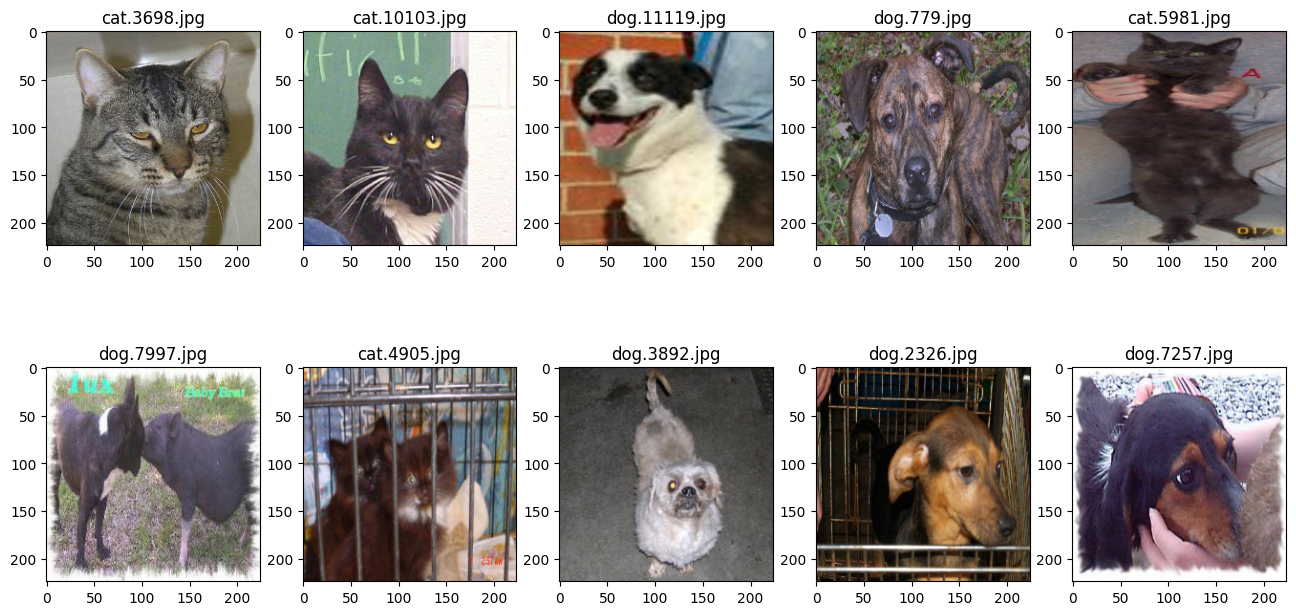

In [ ]:
'''Как выглядят данные'''

%matplotlib inline
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(16, 8))
for i, path in enumerate(train_files[:10], 1):
    subplot = fig.add_subplot(2, 5, i)
    subplot.set_title('%s' % path.split('/')[-1])
    img = cv2.imread(path)[...,::-1]
    img = cv2.resize(img, IMG_SIZE)
    plt.imshow(img)

4. Загрузка предобученной нейросети

In [ ]:
base_model = ResNet50(weights='imagenet',
                      include_top=False,
                      input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))

94765736/94765736 [==============================] - 3s 0us/step


In [ ]:
base_model.summary() #что есть в нейросети

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                       

5. Изменение модели

In [ ]:
'''Фиксируем все веса предобученной нейросети'''
for layer in base_model.layers:
    layer.trainable = False

x = base_model.layers[-5].output

'''Операция глобального усреднения'''
x = tf.keras.layers.GlobalAveragePooling2D()(x)

'''Усложнение нейросети и слой Dropout для предотвращения переобучения'''
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.Model(inputs=base_model.input, outputs=x, name='dogs_vs_cats')

In [ ]:
model.summary()

Model: "dogs_vs_cats"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                   

6. Обучение нейросети

In [ ]:
'''Компилируем модель'''

model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
val_samples = 200

shuffle(train_files)
validation_data = next(fit_generator(train_files[:val_samples], val_samples))
train_data = fit_generator(train_files[val_samples:])

'''Обучение измененной модели'''
model.fit(train_data,
          steps_per_epoch=10,
          epochs=10,
          validation_data=validation_data)

Epoch 1/10
10/10 [==============================] - 22s 888ms/step - loss: 0.5831 - accuracy: 0.7656 - val_loss: 0.4091 - val_accuracy: 0.9450
Epoch 2/10
10/10 [==============================] - 3s 348ms/step - loss: 0.3199 - accuracy: 0.9625 - val_loss: 0.2230 - val_accuracy: 0.9700
Epoch 3/10
10/10 [==============================] - 3s 313ms/step - loss: 0.1911 - accuracy: 0.9531 - val_loss: 0.1455 - val_accuracy: 0.9600
Epoch 4/10
10/10 [==============================] - 5s 561ms/step - loss: 0.1145 - accuracy: 0.9875 - val_loss: 0.1093 - val_accuracy: 0.9700
Epoch 5/10
10/10 [==============================] - 3s 272ms/step - loss: 0.0897 - accuracy: 0.9781 - val_loss: 0.0924 - val_accuracy: 0.9700
Epoch 6/10
10/10 [==============================] - 2s 214ms/step - loss: 0.0806 - accuracy: 0.9844 - val_loss: 0.0829 - val_accuracy: 0.9700
Epoch 7/10
10/10 [==============================] - 2s 253ms/step - loss: 0.0881 - accuracy: 0.9750 - val_loss: 0.0778 - val_accuracy: 0.9700
Epoch

In [ ]:
model.save('cats-dogs-resnet50.hdf5') #сохраняем модель

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


7. Делаем предсказания

In [ ]:
test_image_generator = image_generator(test_files, batch_size, IMG_SIZE)

num_test_images = len(test_files)

steps_per_epoch = (num_test_images + batch_size - 1) // batch_size

In [ ]:
test_pred = model.predict(
    test_image_generator, steps=steps_per_epoch)

391/391 [==============================] - 72s 183ms/step


<ipython-input-25-b19862c6efec>:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  subplot.set_title('%.2f %s' % (score, os.path.basename(path)))


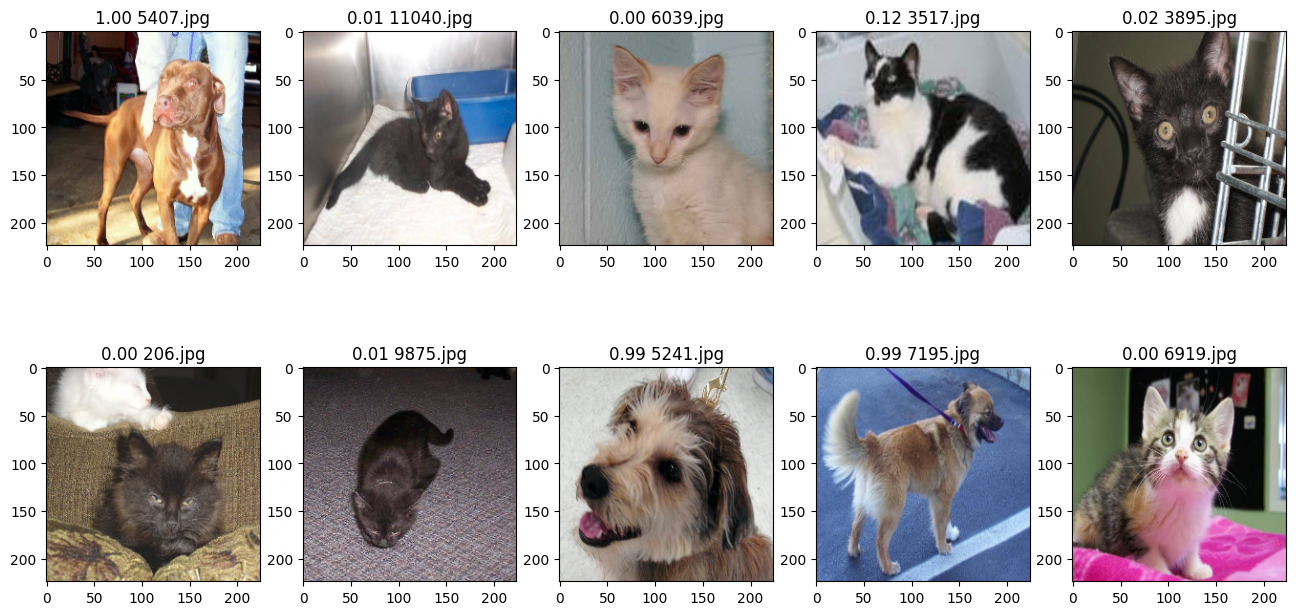

In [ ]:
'''Посмотрим на предсказания'''

fig = plt.figure(figsize=(16, 8))
for i, (path, score) in enumerate(zip(test_files[:10], test_pred[:10]), 1):
    subplot = fig.add_subplot(2, 5, i)
    subplot.set_title('%.2f %s' % (score, os.path.basename(path)))
    img = cv2.imread(path)[...,::-1]
    img = cv2.resize(img, IMG_SIZE)
    subplot.imshow(img)

8. Загрузка предсказаний на Kaggle

In [ ]:
'''Создадим файл, куда запишем все предсказанные классы для каждого изображения'''

with open('sample_subm_dogs_cats.csv', 'w') as dst:
    dst.write('id,label\n')
    for path, score in zip(test_files, test_pred):
        dst.write('%s,%f\n' % (re.search('(\d+).jpg$', path).group(1), score))

<ipython-input-22-a5ea8e6c102d>:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dst.write('%s,%f\n' % (re.search('(\d+).jpg$', path).group(1), score))


Файл загрузим на Kaggle. Полученный результат функции потерь: 0.09034